In [1]:
#引入训练好的VGG16
from keras.applications import VGG16
conv_base=VGG16(weights="imagenet",
                include_top=False,      #是否包含全连接层
                input_shape=(150,150,3))
conv_base.trainable = False


Using TensorFlow backend.


In [2]:
#图片的训练路径和验证路径
train_dir = r'F:\dogs-vs-cats\数据集\train'
validation_dir = r'F:\dogs-vs-cats\数据集\validation'


In [3]:
#用VGG16进行特征提取
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20              #生成器每次生成的图片数目
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))   #输入密集连接层的大小
    labels = np.zeros(shape=sample_count)                #label的大小
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,         #每次生成batch_size张照片
        class_mode='binary')           #标签是binary
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
        return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
#将之前的数据展平
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
#密集连接层进行分类
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])
history = model.fit(train_features, train_labels,
    epochs=30,
    #batch_size=20,
    validation_data=(validation_features, validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 612us/step - loss: 0.6966 - acc: 0.9875 - val_loss: 0.6907 - val_acc: 0.9930

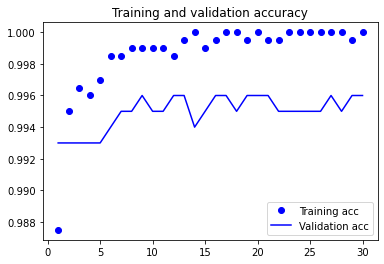

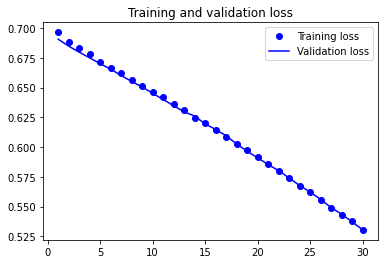

In [6]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()